In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from livelossplot import PlotLosses
device = torch.device('cuda')

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
cotton_price = 0.4
nitrogen_cost = 1.0
nitrogen_ratio = nitrogen_cost/cotton_price
sq_rate = 100
sq_yield = 4500
rst_b2g = -0.02

In [4]:
trial = np.load('../data/Trial_Design.npy')
trial_names = np.load('../data/Trial_Design_names.npy', allow_pickle=True)
trial_coords = np.load('../data/Trial_Design_coords.npy')
trial_coords_idx = np.int0(np.floor(trial_coords/3))
n = trial_coords.shape[0]

rst_sim = np.load('../data/Trial_sim.npy')

In [25]:
exp_name = 'size6_p100'
idx = np.where(trial_names == exp_name)[0][0]

In [26]:
rep = trial[6].copy()
rep[np.isnan(trial[idx])] = 0
repdm = rep[:,:,None] == np.unique(rep)[None, None]
rep = repdm.argmax(-1).astype('float')
ridx = np.stack(np.where(repdm[:,:,1:]))
ridx = np.stack([ridx[:2,ridx[2] == i] for i in np.unique(ridx[2])], 1)
trial_rst = trial[idx][ridx[0], ridx[1]]

rept = torch.tensor(rep[None,None], device = device)
for i in range(100):
    repn = F.max_pool2d(rept, 3, 1, 1)
    rept[rept == 0] = repn[rept == 0]
repf = rept.cpu().numpy()[0,0]
repf = repf.astype('int') - 1

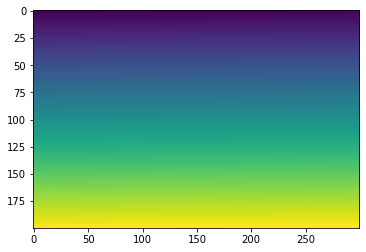

In [28]:
plt.imshow(rep)

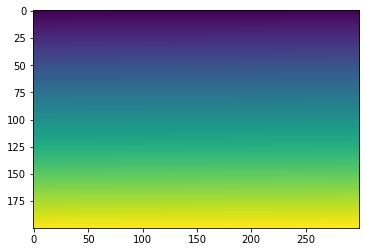

In [29]:
plt.imshow(repf)

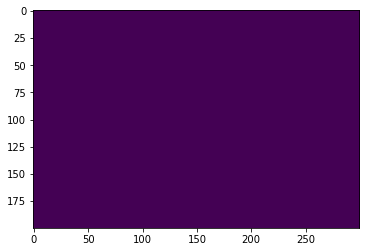

In [30]:
plt.imshow(trial_rst.mean(-1)[repf])

In [31]:
b0_true = rst_sim[:100,ridx[0], ridx[1]]
b1_true = rst_sim[100:,ridx[0], ridx[1]]

rst_optr = sq_rate * (1 + 0.25 * b1_true) 
rst_optr = np.clip(rst_optr, 0, 200)

rst_b1 = -2 * rst_b2g * rst_optr + nitrogen_ratio
rst_b0 = sq_yield * (1 + 0.05 * b0_true)
rst_b0 = rst_b0 - (rst_b1 * rst_optr + rst_b2g * rst_optr **2) 

rate_var = 12.5
inp_rate = sq_rate + rate_var * trial_rst
rst_yield_obs =  rst_b0 + rst_b1 * inp_rate + rst_b2g * inp_rate**2

y = rst_yield_obs.reshape(-1,1)
X = inp_rate.reshape(-1,1)

y_std = StandardScaler().fit(y)
y = y_std.transform(y).reshape(rst_yield_obs.shape)

X_std = StandardScaler().fit(X)
X = X_std.transform(X).reshape(inp_rate.shape)

p = np.array([0,1,2])[:,None,None]
X = X[None,None] ** (np.ones((3, *X.shape)) * p)

c = y[:,None].repeat(3,1)
c[:,1:] = 0
c = torch.tensor(c, device = device, requires_grad = True)

X = torch.tensor(X, device = device)
y = torch.tensor(y, device = device)

In [32]:
criterion = nn.MSELoss()

In [33]:
learning_rate = 0.1
optimizer = torch.optim.Adam((c,), learning_rate)

In [34]:
# Creates the loss plot:
liveloss = PlotLosses()

for i in trange(100):
    # Clean the gradients
    optimizer.zero_grad()

    # Enforce spatial correlation:
    cm = c.mean(-1)[:,:,:,None].repeat(1,1,1,c.shape[-1])

    # Enforce fixed (global) paramter for the second order effect:
    cm[:,2] = cm[:,2].mean()

    # Predict the yield based on the spatial parameters and the rates applied:
    pred = (X * cm).sum(1)

    # Calc the loss using the MSE between actual and predicted yield:
    loss = criterion(pred, y)

    # Also minimize the distance between the raw parameters and their spatially smothed version:
    loss += criterion(cm, c)

    # Calc the gradients:
    loss.backward()

    # Update model parameters:
    optimizer.step()

    # Save the current loss for plotting:
    liveloss.update({
        'log loss': loss.item()
    })


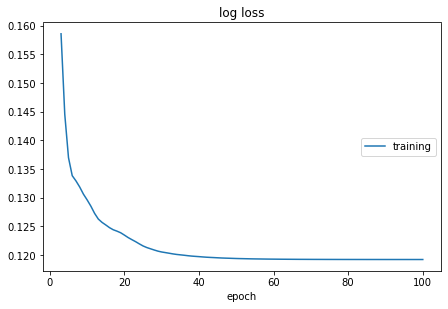

log loss:
training   (min:    0.119, max:    0.230, cur:    0.119)


In [35]:
liveloss.draw()

In [36]:
ypred = pred.data.cpu().numpy()

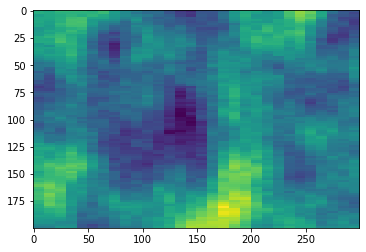

In [37]:
idx = 4
plt.imshow(ypred[idx].mean(-1)[repf])

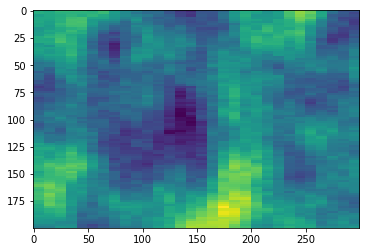

In [38]:
plt.imshow(rst_yield_obs[idx].mean(-1)[repf])

In [39]:
X_testr = torch.linspace(0, 200, 200, device = device)
X_cost = X_testr[:,None,None] * nitrogen_cost
X_test = (X_testr - X_std.mean_[0]) /  X_std.scale_[0]
p = torch.tensor([[0,1,2]], device = device)[:,:,None,None]
X_test = X_test[:,None,None,None] ** (torch.ones_like(c)[0][None] * p)

best_idx = []
for i in range(len(c)):
    y_test = (X_test * cm[i]).sum(1)
    y_test = y_std.mean_[0] + (y_std.scale_[0] * y_test)
    y_net_pred = y_test * cotton_price - X_cost
    best_idx.append(y_net_pred.argmax(0))

best_idx = torch.stack(best_idx)
rst_optr_pred = X_testr[best_idx].cpu().numpy()
rst_optr_pred = rst_optr_pred.mean(-1)[:,repf]
rst_optr = rst_optr.mean(-1)[:,repf]

In [40]:
# np.save(f'../data/{exp_name}_s.npy', rst_optr_pred)

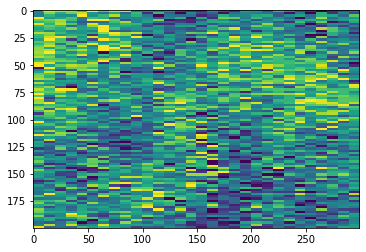

In [41]:
plt.imshow(rst_optr_pred[idx])

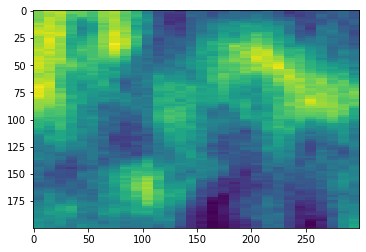

In [42]:
plt.imshow(rst_optr[idx])

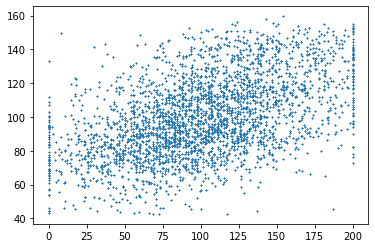

In [43]:
plt.scatter(rst_optr_pred[idx].reshape(-1), rst_optr[idx].reshape(-1), alpha=0.5, s = 0.1)

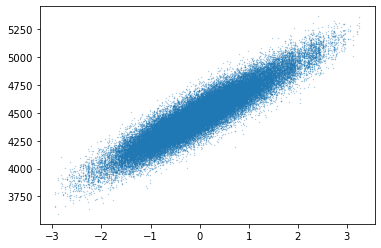

In [44]:
plt.scatter(ypred[idx].reshape(-1), rst_yield_obs[idx].reshape(-1), alpha=0.5, s = 0.1)